In [2]:
# Path injection to resolve 'src' imports when launching from notebooks/
import sys
from pathlib import Path

_nb_root = Path.cwd()
# Ascend if current working directory is notebooks (handle different launch contexts)
_repo_root = _nb_root if (_nb_root / 'src').exists() else _nb_root.parent
_src = _repo_root / 'src'
if _src.exists():
    added = []
    for p in (str(_repo_root), str(_src)):
        if p not in sys.path:
            sys.path.insert(0, p)
            added.append(p)
    print('sys.path augmented with:', added)
else:
    print('Warning: src directory not found at expected path:', _src)
    print('CWD:', _nb_root)
    print('Head of sys.path:', sys.path[:6])

sys.path augmented with: ['/Users/zak/Repos/E-commerce-Demand-Forecasting', '/Users/zak/Repos/E-commerce-Demand-Forecasting/src']


# Data Quality & EDA Notebook

Purpose: Rapid assessment of panel integrity (duplicates, gaps, zeros, outliers) and basic seasonality patterns. This complements the modeling notebook and demonstrates data curation & exploration skills.

In [3]:
# Imports & paths
from pathlib import Path
import pandas as pd, numpy as np, math, json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from src.data import validate
PANEL_PATH = Path('data/processed/m5_panel_subset.parquet')
print('Panel path ->', PANEL_PATH)

Panel path -> data/processed/m5_panel_subset.parquet


In [4]:
# Load panel or synthesize if missing (mirrors training notebook approach).
if PANEL_PATH.exists():
    panel_df = pd.read_parquet(PANEL_PATH)
else:
    print('Panel missing -> generating synthetic sample (20 items, 180 days).')
    items = [f'ITEM_{i:03d}' for i in range(20)]
    dates = pd.date_range('2024-01-01', periods=180, freq='D')
    rows = []
    rng = np.random.default_rng(42)
    for item in items:
        base = rng.integers(5, 25)
        seasonal = np.sin(np.linspace(0, 8*math.pi, len(dates))) * rng.uniform(3,7)
        noise = rng.normal(0, 1.2, len(dates))
        demand = (base + seasonal + noise).clip(min=0).round(2)
        for d,v in zip(dates, demand):
            rows.append({'item_id': item, 'date': d, 'demand': float(v)})
    panel_df = pd.DataFrame(rows)
print('Rows:', len(panel_df), '| Items:', panel_df.item_id.nunique(), '| Date span:', panel_df.date.min(), '->', panel_df.date.max())
panel_df.head()

Rows: 4000 | Items: 20 | Date span: 2024-01-01 00:00:00 -> 2024-07-18 00:00:00


,item_id,date,demand
0,ITEM_000,2024-01-01,11.90
1,ITEM_000,2024-01-02,11.30
2,ITEM_000,2024-01-03,11.60
3,ITEM_000,2024-01-04,18.30
4,ITEM_000,2024-01-05,15.64


## 1. High-Level Summary

In [5]:
summary = {
    'n_rows': len(panel_df),
    'n_items': panel_df.item_id.nunique(),
    'date_min': str(panel_df.date.min()),
    'date_max': str(panel_df.date.max()),
    'total_days': (panel_df.date.max() - panel_df.date.min()).days + 1,
}
display(pd.Series(summary, name='panel_summary'))

n_rows                       4000
n_items                        20
date_min      2024-01-01 00:00:00
date_max      2024-07-18 00:00:00
total_days                    200
Name: panel_summary, dtype: object

## 2. Run Validation Checks

In [6]:
report = validate.run_all(panel_df.copy())
report['summary']['_generated_at'] = datetime.utcnow().isoformat()
report_path = Path('artifacts/data_quality_report.json')
report_path.parent.mkdir(parents=True, exist_ok=True)
with open(report_path, 'w') as f: json.dump(report, f, indent=2)
print('Saved report ->', report_path)
pd.DataFrame([{'check': k, 'passed': v.get('passed')} for k,v in report['summary'].items() if not k.startswith('_')])

Saved report -> artifacts/data_quality_report.json


,check,passed
0,no_duplicate_item_date_rows,True
1,non_negative_demand,True
2,date_continuity_daily,True
3,zero_demand_ratios,True
4,demand_outlier_iqr,True


### Gap Details (if any)

In [7]:
gap_details = report['summary']['date_continuity_daily']['details']
if gap_details['items_with_gaps'] == 0:
    print('No date gaps detected.')
else:
    display(pd.DataFrame(gap_details['gap_details_sample']))

No date gaps detected.


## 3. Zero Demand Ratios

Overall zero-demand ratio: 0.002


,item_id,total,zeros,zero_ratio
0,ITEM_013,200,8,0.040
1,ITEM_006,200,1,0.005
2,ITEM_000,200,0,0.000
3,ITEM_011,200,0,0.000
4,ITEM_018,200,0,0.000
5,ITEM_017,200,0,0.000
6,ITEM_016,200,0,0.000
7,ITEM_015,200,0,0.000
8,ITEM_014,200,0,0.000
9,ITEM_012,200,0,0.000


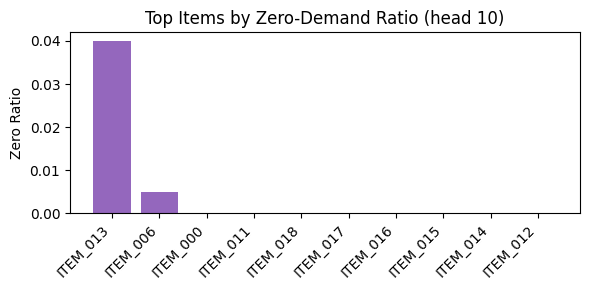

In [9]:
# Zero demand ratio details and top items visualization
zero_info = report['summary']['zero_demand_ratios']['details']
print(f"Overall zero-demand ratio: {zero_info['overall_zero_ratio']:.3f}")
zero_df = pd.DataFrame(zero_info['top_items_zero_ratio'])
if not zero_df.empty:
    display(zero_df.head(10))
    plt.figure(figsize=(6,3))
    top_plot = zero_df.head(10)
    plt.bar(top_plot['item_id'], top_plot['zero_ratio'], color='tab:purple')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Zero Ratio')
    plt.title('Top Items by Zero-Demand Ratio (head 10)')
    plt.tight_layout()
else:
    print('No zero-demand items summary available.')

Outlier ratio: 0.0005 | Bounds: {'lower': -2.1700000000000035, 'upper': 34.150000000000006}


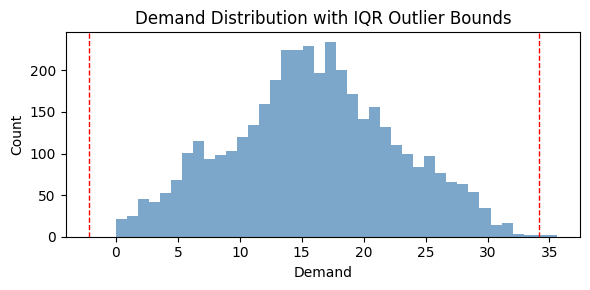

In [10]:
# Outlier ratio (global IQR) and simple distribution plot
out_info = report['summary']['demand_outlier_iqr']['details']
print('Outlier ratio:', f"{out_info['outlier_ratio']:.4f}", '| Bounds:', out_info['thresholds'])
plt.figure(figsize=(6,3))
vals = panel_df['demand']
plt.hist(vals, bins=40, alpha=0.7, color='steelblue')
plt.axvline(out_info['thresholds']['lower'], color='red', linestyle='--', linewidth=1)
plt.axvline(out_info['thresholds']['upper'], color='red', linestyle='--', linewidth=1)
plt.title('Demand Distribution with IQR Outlier Bounds')
plt.xlabel('Demand')
plt.ylabel('Count')
plt.tight_layout()

Heatmap diagnostics -> items: 20 | dates: 100 | nonzero cells: 2000


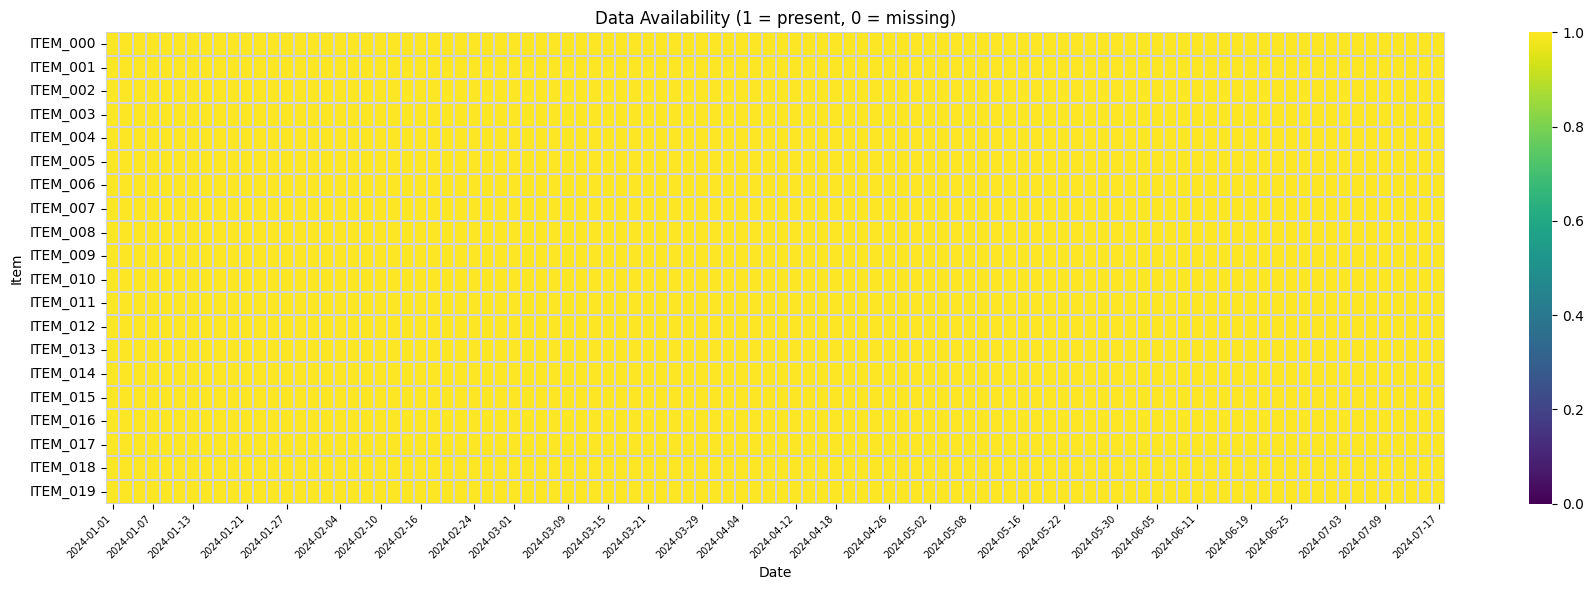

In [ ]:
# Conditional availability heatmap: only plot if there are missing daily entries within each item's own min->max date span.
import numpy as np
subset_items = panel_df.item_id.unique()[:30]
sub_df = panel_df[panel_df.item_id.isin(subset_items)].copy()
if not pd.api.types.is_datetime64_any_dtype(sub_df['date']):
    sub_df['date'] = pd.to_datetime(sub_df['date'])

presence_frames = []
for item, grp in sub_df.groupby('item_id'):
    grp = grp.sort_values('date')
    dmin, dmax = grp['date'].min(), grp['date'].max()
    full_range = pd.date_range(dmin, dmax, freq='D')
    # Series of 1 for existing dates
    present_series = pd.Series(1, index=grp['date'].values)
    # Reindex over full range -> missing become 0
    present_full = present_series.reindex(full_range, fill_value=0)
    presence_frames.append(pd.DataFrame({
        'item_id': item,
        'date': present_full.index,
        'present': present_full.values.astype(int)
    }))

full_presence = pd.concat(presence_frames, ignore_index=True)
pivot = (full_presence.pivot_table(index='item_id', columns='date', values='present', fill_value=0)
         .sort_index())
missing_total = int((pivot == 0).sum().sum())
items_with_gaps = int(((pivot == 0).sum(axis=1) > 0).sum())
print(f"Gap diagnostics -> items: {pivot.shape[0]} | date_cols: {pivot.shape[1]} | missing_cells: {missing_total} | items_with_gaps: {items_with_gaps}")

if missing_total == 0:
    print('All items have full contiguous daily coverage within their observed spans. Heatmap skipped (nothing missing).')
else:
    # Focus columns (dates) that have at least one missing value to keep plot compact
    cols_with_missing = (pivot == 0).any(axis=0)
    pivot_focus = pivot.loc[:, cols_with_missing]
    short_cols = [d.strftime('%Y-%m-%d') for d in pivot_focus.columns]
    pivot_focus.columns = short_cols
    fig_width = min(18, 0.25 * pivot_focus.shape[1] + 3)
    fig_height = max(4, 0.30 * pivot_focus.shape[0])
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.heatmap(pivot_focus, cmap='Reds', cbar=False, vmin=0, vmax=1, linewidths=0.1, linecolor='lightgrey')
    ax.set_title('Missing Day Heatmap (red=missing, white=present)')
    ax.set_xlabel('Date (only dates with ≥1 gap)')
    ax.set_ylabel('Item')
    # Tick thinning if wide
    if pivot_focus.shape[1] > 40:
        idxs = np.linspace(0, pivot_focus.shape[1]-1, 40, dtype=int)
        ax.set_xticks(idxs + 0.5)
        ax.set_xticklabels([short_cols[i] for i in idxs], rotation=45, ha='right', fontsize=7)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.tight_layout()